In [2]:
import pandas as pd
data1 = pd.read_excel('Atm_7.xlsx', 'Sheet1')
#data1.set_index(['DT'],inplace=True)

In [4]:
import pandas as pd
import numpy as np 
data = pd.read_excel('no_hl.xlsx', 'Sheet1')
bins = [-np.inf, 30, 60, 90, 120, 150, 180, 210, np.inf]
data['EMIbins'] = pd.cut(data['EMI_NMI'], bins)
data = data.drop(['EMI_NMI'], axis = 1)
bank_cust = data.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = bank_cust.apply(le.fit_transform)
X = bank_cust.drop(['HL'], axis = 1)
X = X.drop(['V_CUST_ID'], axis = 1)
y = bank_cust['HL']

In [84]:
mask = (data1['DT'] > '2017-04-01') & (data1['DT'] <= '2020-01-31')
data = data1.loc[mask]
data.set_index(['DT'],inplace=True)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import sklearn
import scipy
import shap

In [85]:
#data.head()
#data['DT'] = pd.to_datetime(data['DT'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017 entries, 2017-04-03 to 2020-01-31
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DAY_WEEK        1017 non-null   object 
 1   DAY             1017 non-null   int64  
 2   MONTH           1017 non-null   int64  
 3   YEAR            1017 non-null   int64  
 4   TXN             1017 non-null   int64  
 5   MOVING_AVERAGE  1017 non-null   float64
 6   HOLIDAY         1017 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 63.6+ KB


count      1017.0
mean     402910.0
std      160324.0
min        5500.0
25%      289800.0
50%      406100.0
75%      508000.0
max      857500.0
Name: TXN, dtype: float64

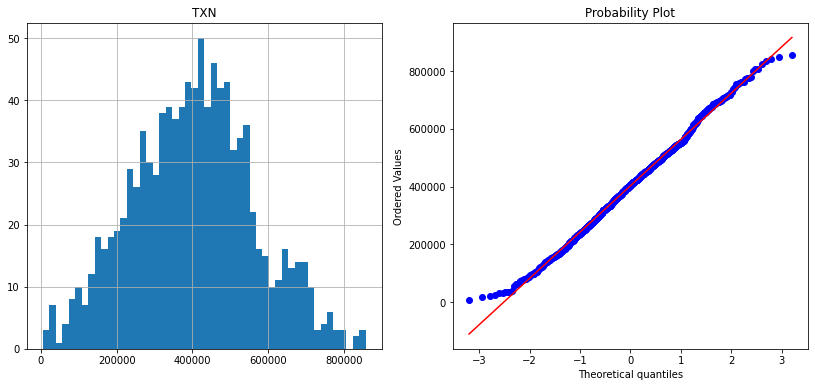

In [88]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['TXN'].hist(bins=50)
plt.title('TXN')
plt.subplot(1,2,2)
scipy.stats.probplot(data['TXN'], plot=plt);
data['TXN'].describe().T.round()

In [90]:
# Copy the original data
features = data.copy()
# Select the numeric columns
numeric_subset = data[['MONTH','YEAR','MOVING_AVERAGE', 'TXN']]
# Select the categorical columns
# dropped atm_name
categorical_subset = data[['DAY_WEEK','HOLIDAY']]
# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset)
# Join the two dataframes using concat
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [3]:
import pandas as pd
import numpy as np 
data = pd.read_excel('no_hl.xlsx', 'Sheet1')
bins = [-np.inf, 30, 60, 90, 120, 150, 180, 210, np.inf]
data['EMIbins'] = pd.cut(data['EMI_NMI'], bins)
data = data.drop(['EMI_NMI'], axis = 1)
bank_cust = data.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = bank_cust.apply(le.fit_transform)
X = bank_cust.drop(['HL'], axis = 1)
X = X.drop(['V_CUST_ID'], axis = 1)
y = bank_cust['HL']

In [7]:
#X = features.copy().drop(columns = ['TXN', 'MONTH','YEAR', 'HOLIDAY_W'])
#y = features['TXN'].copy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of Xtrain and Xtest: ', len(Xtrain), len(Xtest))
print('length of ytrain and ytest: ', len(ytrain), len(ytest))

length of Xtrain and Xtest:  784607 196152
length of ytrain and ytest:  784607 196152


In [11]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(Xtrain, ytrain)
# make predictions
lin_pred = linear.predict(Xtest)
linpred = pd.DataFrame(lin_pred[-10:]) # predicting last 10 values
linpred.rename(columns = {0: 'lin_predicted'}, inplace=True) # renaming the column
linpred = linpred.round(decimals=0) # rounding the decimal values
d = pd.DataFrame(data['HL']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
linpred.index = d.index #= dt.index
# calling last 10 values of original amt wothdrawn
#linpred.index = d.index # mapping the index of both dataframe
linok = pd.concat([linpred, d], axis=1)
linok['accuracy'] = round(linok.apply(lambda row: row.lin_predicted /row.HL *100, axis = 1),2)
#linok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in linok['accuracy']],index = linok.index)
#linok = linok.assign(day_of_week = lambda x: x.index.day_name())
# Prediction vs Actual
linok

,lin_predicted,HL,accuracy
980749,0.0,1,0.0
980750,1.0,1,100.0
980751,0.0,1,0.0
980752,0.0,1,0.0
980753,0.0,1,0.0
980754,0.0,1,0.0
980755,0.0,1,0.0
980756,0.0,1,0.0
980757,0.0,1,0.0
980758,0.0,1,0.0


In [14]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective = 'reg:squarederror', learning_rate=0.900000012) 
xgb.fit(Xtrain, ytrain)
xgb_pred = xgb.predict(Xtest) 
xgbpred = pd.DataFrame(xgb_pred[-10:]) 
xgbpred.rename(columns = {0: 'xgbpredicted'}, inplace=True) 
xgbpred = xgbpred.round(decimals=0) 
xgbpred.index = d.index
xgbok = pd.concat([xgbpred, d], axis=1)
xgbok['accuracy'] = round(xgbok.apply(lambda row: row.xgbpredicted / row.HL*100, axis = 1),2)
#xgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in xgbok['accuracy']],index = xgbok.index) 
#xgbok = xgbok.assign(day_of_week = lambda 0: x.index.day_name()) 
xgbok 

,xgbpredicted,HL,accuracy
980749,1.0,1,100.0
980750,1.0,1,100.0
980751,1.0,1,100.0
980752,1.0,1,100.0
980753,1.0,1,100.0
980754,1.0,1,100.0
980755,1.0,1,100.0
980756,1.0,1,100.0
980757,1.0,1,100.0
980758,1.0,1,100.0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


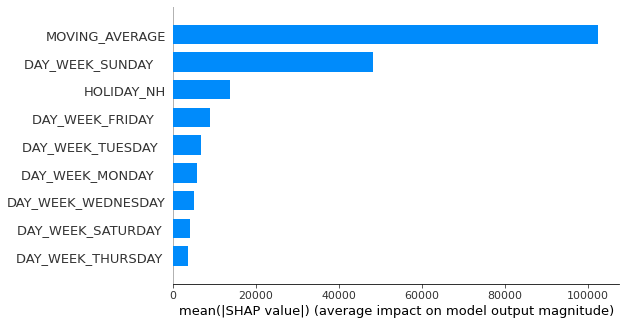

In [94]:
shap_values = shap.TreeExplainer(xgb).shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="bar")

In [95]:
X = data[['DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
y = data['TXN']
#X = data.iloc[:, 2:10].copy()
#y = data.iloc[:, 10].values
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  813 204
length of y_train and y_test:  813 204



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2016-04-01 to 2020-10-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DAY             1544 non-null   int64   
 1   MONTH           1544 non-null   int64   
 2   YEAR            1544 non-null   int64   
 3   MOVING_AVERAGE  1544 non-null   float64 
 4   DAY_WEEK        1544 non-null   category
 5   HOLIDAY         1544 non-null   category
dtypes: category(2), float64(1), int64(3)
memory usage: 63.8 KB


In [96]:
import lightgbm as lgb
import time
# Similarly LGBMRegressor can also be imported for a regression model.
from lightgbm import LGBMClassifier
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, randomstate=42, learning_rate=0.1, n_estimators=100)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric ='rmse', early_stopping_rounds = 10, verbose =50) 
print(gbm)
lgb_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration_) 
lgbpred = pd.DataFrame(lgb_pred[-10:]) 
lgbpred.rename(columns = {0: 'lgbpredicted'}, inplace=True) 
lgbpred = lgbpred.round(decimals=0) 
d = pd.DataFrame(data['TXN']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
lgbpred.index = d.index
lgbok = pd.concat([lgbpred, d], axis=1) 
lgbok['accuracy'] = round(lgbok.apply(lambda row: row.lgbpredicted / row.TXN*100, axis = 1),2)
lgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in lgbok['accuracy']],index = lgbok.index) 
#lgbok = lgbok.assign(day_of_week = lambda 0: x.index.day_name()) 
lgbok 

[LightGBM] [Warning] Unknown parameter: randomstate
LGBMRegressor(objective='regression', randomstate=42)


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,lgbpredicted,TXN,accuracy
DT,,,
2020-01-22,335316.0,345600,97.02%
2020-01-23,370149.0,342400,108.10%
2020-01-24,342276.0,183500,186.53%
2020-01-25,329059.0,288000,114.26%
2020-01-26,213965.0,164600,129.99%
2020-01-27,326229.0,381000,85.62%
2020-01-28,345529.0,416600,82.94%
2020-01-29,394132.0,366000,107.69%
2020-01-30,416254.0,356300,116.83%


In [97]:
X = data[[ 'DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
y = data['TXN']
#X = data.iloc[:, 2:10].copy()
#y = data.iloc[:, 10].values
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

categorical_features_indices = np.where(X.dtypes != np.float)[0]

length of X_train and X_test:  813 204
length of y_train and y_test:  813 204



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
X.dtypes

DAY                  int64
MONTH                int64
YEAR                 int64
MOVING_AVERAGE     float64
DAY_WEEK          category
HOLIDAY           category
dtype: object

In [98]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(random_seed = 42, iterations=10,
                          learning_rate=0.8,
                          depth=2)
cat.fit(X_train, y_train, cat_features = categorical_features_indices,  eval_set=[(X_test, y_test)], early_stopping_rounds = 10, verbose =50, plot = True) 
print(gbm)
cat_pred = cat.predict(X_test) 
catpred = pd.DataFrame(cat_pred[-10:]) 
catpred.rename(columns = {0: 'catpredicted'}, inplace=True) 
catpred = catpred.round(decimals=0) 
d = pd.DataFrame(data['TXN']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
catpred.index = d.index #=dt.index
catok = pd.concat([catpred, d], axis=1) 
catok['accuracy'] = round(catok.apply(lambda row: row.catpredicted / row.TXN*100, axis = 1),2)
#catok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in catok['accuracy']],index = catok.index) 
#catok = catok.assign(day_of_week = lambda 0: x.index.day_name()) 
catok

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 125616.9387568	test: 132692.9116346	best: 132692.9116346 (0)	total: 6.42ms	remaining: 57.8ms
9:	learn: 109270.6923302	test: 106769.4887298	best: 106769.4887298 (9)	total: 58.2ms	remaining: 0us

bestTest = 106769.4887
bestIteration = 9

LGBMRegressor(objective='regression', randomstate=42)


,catpredicted,TXN,accuracy
DT,,,
2020-01-22,323411.0,345600,93.58
2020-01-23,323411.0,342400,94.45
2020-01-24,311315.0,183500,169.65
2020-01-25,323411.0,288000,112.30
2020-01-26,86441.0,164600,52.52
2020-01-27,323411.0,381000,84.88
2020-01-28,323411.0,416600,77.63
2020-01-29,323411.0,366000,88.36
2020-01-30,336266.0,356300,94.38


In [99]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [100]:
print('Cat',mean_absolute_percentage_error(d,catpred))
print('lgb',mean_absolute_percentage_error(d,lgbpred))
print('xgb',mean_absolute_percentage_error(d,xgbpred))
print('lin',mean_absolute_percentage_error(d,linpred))

Cat 21.065111764784323
lgb 20.856726649535172
xgb 25.78605937313628
lin 22.969879566951615


In [66]:
print('Cat',mean_absolute_percentage_error(d,catpred))
print('lgb',mean_absolute_percentage_error(d,lgbpred))
print('xgb',mean_absolute_percentage_error(d,xgbpred))
print('lin',mean_absolute_percentage_error(d,linpred))

Cat 43.13912605653676
lgb 40.76087451976975
xgb 61.5187644645813
lin 51.68824883048089


In [64]:
report = pd.concat([d['TXN'],linok['lin_predicted'],catok['catpredicted'],lgbok['lgbpredicted'], xgbok['xgbpredicted']], axis=1)
report

,TXN,lin_predicted,catpredicted,lgbpredicted,xgbpredicted
DT,,,,,
2021-10-20,160500,242875.0,198644.0,219917.0,234418.0
2021-10-21,252000,238997.0,198644.0,172824.0,74645.0
2021-10-22,158000,185833.0,187658.0,144652.0,167222.0
2021-10-23,359500,237678.0,198644.0,183244.0,296441.0
2021-10-24,164000,70843.0,70940.0,118935.0,14085.0
2021-10-25,96000,233552.0,198644.0,189341.0,243371.0
2021-10-26,156000,232182.0,198644.0,176171.0,98765.0
2021-10-27,139500,226086.0,198644.0,197654.0,58803.0
2021-10-28,120500,216242.0,198644.0,212315.0,269217.0


<AxesSubplot:xlabel='DT'>

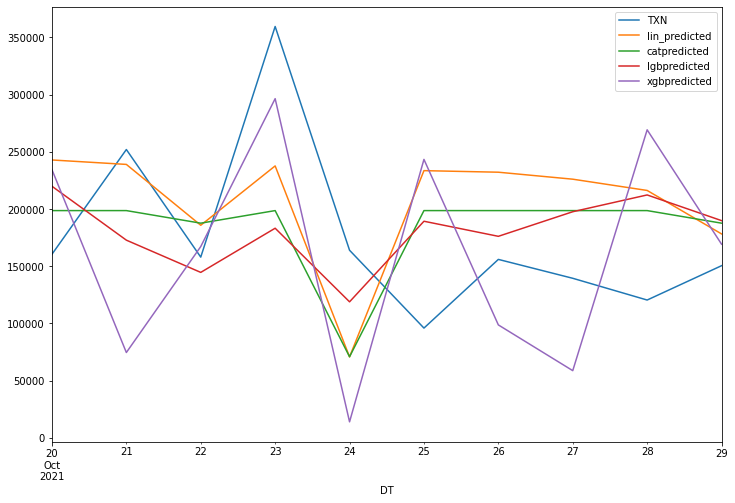

In [65]:
report.plot(figsize=(12,8))